In [1]:
"""
Patrick Brosseau 2023/01/31

Artificial neural network (ANN) is used to classify frequency resolved optical gating (FROG) spectrograms based on the phase
of the corresponding pulse.

"""


import numpy as np
from numpy import mean
from numpy import std
from numpy.random import random, seed
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter,gaussian_filter1d
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
import tensorflow as tf

from tqdm import tqdm
import glob

import pypret
from pypret import (FourierTransform, Pulse, random_gaussian, random_pulse,
                    PNPS, material, Retriever, lib, graphics, MeshDataPlot)

def super_gaus(x,a,x0,sigma,order):
    return a*np.exp(-((x-x0)**2/(2*sigma**2))**order)

# Generate FROGs

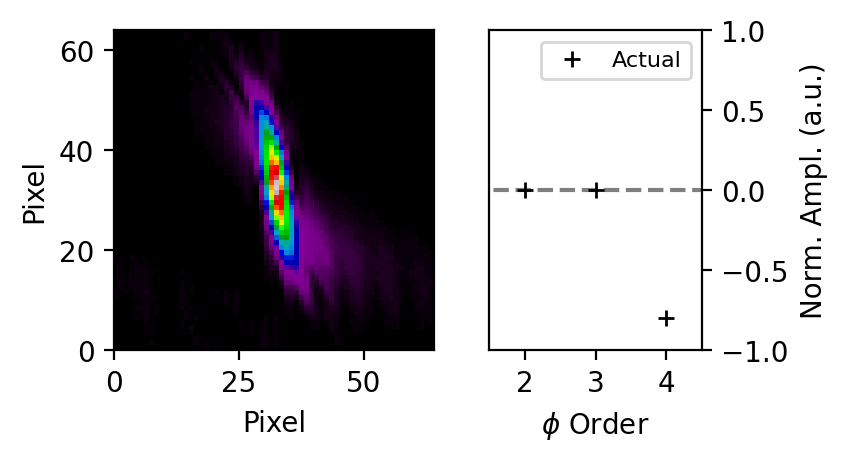

In [2]:
#Generate time-frequency grid
ft = pypret.FourierTransform(64, dt=4e-15)
cwl = 800e-9 #central wavelength
width = 60e-9
supergaussian_order = 1
amplitude = 1
pulse = pypret.Pulse(ft, cwl)

exp_spectrum = super_gaus(pulse.wl,amplitude,cwl,width,supergaussian_order)
pulse.spectrum = np.sqrt(np.abs(exp_spectrum))

#Fourier transform limited pulse length
FTL_FWHM = pulse.fwhm(dt=pulse.dt/100)

w = 6.28*2.9979e+8/pulse.wl
w0 = 6.28*2.9979e+8/cwl

#phase across the pulse is given by a fourth order polynomial
#r1,r2 and r3 scale the second, third and fourth order polynomial terms, normalized between -1 and 1
r1 = 0
r2 = 0
r3 = -0.8
phi2,phi3,phi4 = [r1*1e-28,r2*1e-42,r3*1e-56]
phase = 0.5*phi2*(w-w0)**2 - (1/6)*phi3*(w-w0)**3 + (1/24)*phi4*(w-w0)**4
pulse.spectrum = pulse.spectrum*np.exp(1j*phase)
    
#TG-FROG is generated based off the pulse created above
pnps = pypret.PNPS(pulse, "frog", "tg")
pnps.calculate(pulse.spectrum, pulse.t)
original_spectrum = pulse.spectrum

#FROG trace normalized
Z = pnps.trace.data.T/np.max(pnps.trace.data.T)
noise = 0.1*random((Z.shape))
#     Z = np.abs(Z + noise)


#Plot FROG trace and normalized polynomial coefficients
fig = plt.figure(figsize=(4,2),dpi=200)
gs = fig.add_gridspec(1, 2,  width_ratios=(2, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.01, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plt.sca(ax1)
plt.pcolormesh(Z, cmap="nipy_spectral")
plt.xlabel("Pixel")
plt.ylabel("Pixel")
ax1.set_aspect(1)

plt.sca(ax2)
plt.plot([2,3,4],[r1,r2,r3],label="Actual",linestyle="none",marker="+",c="k")
plt.legend(fontsize=8)
plt.xlabel("$\phi$ Order")
plt.ylabel("Norm. Ampl. (a.u.)")
plt.hlines(0,0,5,linestyle="--",color="k",alpha=0.5)
plt.xlim(1.5,4.5)
plt.ylim(-1,1)
plt.xticks([2,3,4])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# Generate training and labels

In [3]:
# seed random number generator
seed(1)
numspec = 5000 #number of FROG traces in training set

train_images = []
train_labels = []
for rep in tqdm(range(0,numspec)):
    #Generate time-frequency grid
    cwl = 800e-9 #central wavelength
    width = 60e-9
    supergaussian_order = 1
    amplitude = 1
    pulse = pypret.Pulse(ft, cwl)
    
    rcwl1 = (random()*10-5)*1e-9
    rwidth1 = (random()*60-5)*1e-9
    
    exp_spectrum = super_gaus(pulse.wl,1,cwl+rcwl1,width+rwidth1,1)
    pulse.spectrum = np.sqrt(np.abs(exp_spectrum))

    #Fourier transform limited pulse length
    FTL_FWHM = pulse.fwhm(dt=pulse.dt/100)
    
    w = 6.28*2.9979e+8/pulse.wl
    w0 = 6.28*2.9979e+8/cwl
    r1 = random()*2-1
    r2 = random()*2-1
    r3 = random()*2-1
    phi2,phi3,phi4 = [r1*1e-28,r2*1e-42,r3*1e-56]    
    phase = 0.5*phi2*(w-w0)**2 - (1/6)*phi3*(w-w0)**3 + (1/24)*phi4*(w-w0)**4
    pulse.spectrum = pulse.spectrum*np.exp(1j*phase)

    #TG-FROG is generated based off the pulse created above
    pnps = pypret.PNPS(pulse, "frog", "tg")
    pnps.calculate(pulse.spectrum, pulse.t)
    original_spectrum = pulse.spectrum

    #FROG trace normalized
    Z = pnps.trace.data.T/np.max(pnps.trace.data.T)
    noise = 0.1*random((Z.shape))
#     Z = np.abs(Z + noise)

    train_images.append(Z/np.max(Z))
    label = [r1,r2,r3]
    train_labels.append(label)

training_full_set = np.array(train_images)
label_full_set = np.array(train_labels)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 254.60it/s]


# Generate and train model

In [4]:
## Model
# Convolutional 2D neural network
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, 1, activation='relu', input_shape=(64, 64, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, 1, activation='relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(3))
    
    model.compile(loss='mse', optimizer='adam',metrics="accuracy")
    return model

#Shuffle and split training_full_set into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(training_full_set, label_full_set, test_size=0.2, random_state=42)
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
model = get_model(n_inputs, n_outputs)

In [5]:
# fit the model on all data
history = model.fit(X_train, y_train, verbose=2, epochs=20)

Epoch 1/20
125/125 - 15s - loss: 0.1397 - accuracy: 0.6765 - 15s/epoch - 117ms/step
Epoch 2/20
125/125 - 16s - loss: 0.0390 - accuracy: 0.8410 - 16s/epoch - 131ms/step
Epoch 3/20
125/125 - 13s - loss: 0.0227 - accuracy: 0.8880 - 13s/epoch - 104ms/step
Epoch 4/20
125/125 - 13s - loss: 0.0184 - accuracy: 0.9010 - 13s/epoch - 107ms/step
Epoch 5/20
125/125 - 13s - loss: 0.0153 - accuracy: 0.9120 - 13s/epoch - 107ms/step
Epoch 6/20
125/125 - 14s - loss: 0.0133 - accuracy: 0.9153 - 14s/epoch - 112ms/step
Epoch 7/20
125/125 - 13s - loss: 0.0118 - accuracy: 0.9193 - 13s/epoch - 106ms/step
Epoch 8/20
125/125 - 14s - loss: 0.0119 - accuracy: 0.9225 - 14s/epoch - 110ms/step
Epoch 9/20
125/125 - 13s - loss: 0.0102 - accuracy: 0.9280 - 13s/epoch - 107ms/step
Epoch 10/20
125/125 - 14s - loss: 0.0094 - accuracy: 0.9285 - 14s/epoch - 116ms/step
Epoch 11/20
125/125 - 17s - loss: 0.0091 - accuracy: 0.9330 - 17s/epoch - 133ms/step
Epoch 12/20
125/125 - 15s - loss: 0.0085 - accuracy: 0.9355 - 15s/epoch - 

# Verify Model Convergence

32/32 [==============================] - 1s 37ms/step - loss: 0.0082 - accuracy: 0.9080

Test accuracy: 0.9079999923706055


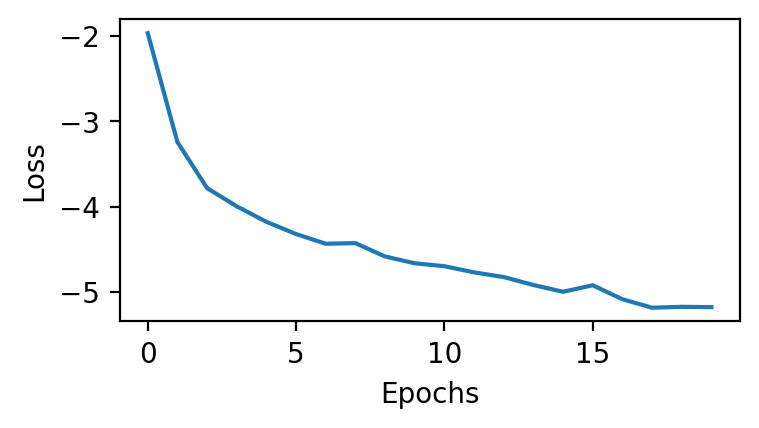

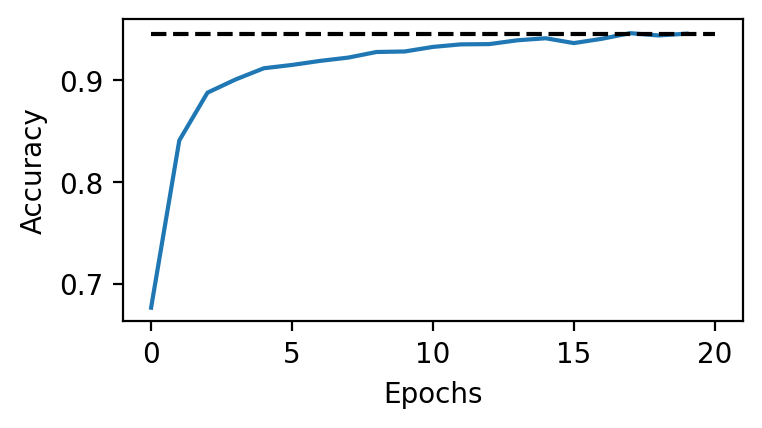

In [6]:
plt.figure(figsize=(4,2),dpi=200)
plt.plot(np.log(history.history['loss']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.hlines(history.history['loss'][-1],0,len(history.history['loss']),color="k",linestyle="--")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', score[1])

# Validate Model

1/1 [==============================] - 0s 191ms/step


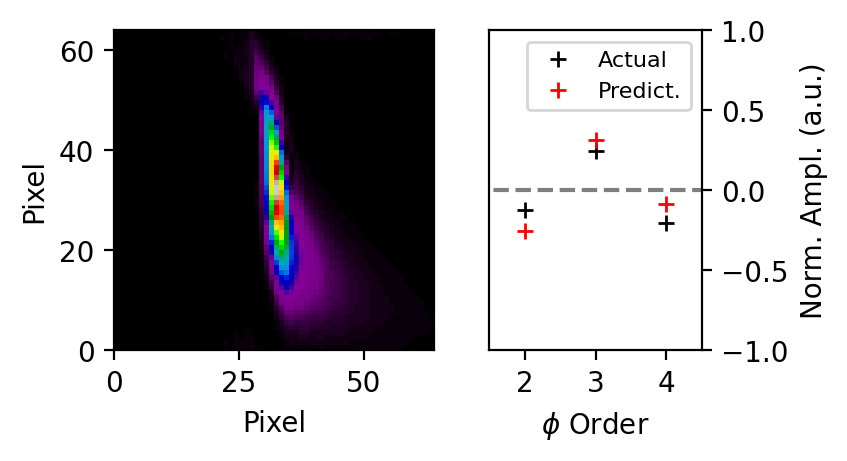

In [7]:
#Test model by predicting phase order labels for test spectra
test_ind = 510
test_FROG= X_test[test_ind,:,:]

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)

fig = plt.figure(figsize=(4,2),dpi=200)
gs = fig.add_gridspec(1, 2,  width_ratios=(2, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.01, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plt.sca(ax1)
plt.pcolormesh(test_FROG, cmap="nipy_spectral")
plt.xlabel("Pixel")
plt.ylabel("Pixel")
ax1.set_aspect(1)

plt.sca(ax2)
plt.plot([2,3,4],y_test[test_ind][0:64],label="Actual",linestyle="none",marker="+",c="k")
plt.plot([2,3,4],yhat[0][0:64],label="Predict.",linestyle="none",marker="+",c="r")
plt.legend(fontsize=8)
plt.xlabel("$\phi$ Order")
plt.ylabel("Norm. Ampl. (a.u.)")
plt.hlines(0,0,5,linestyle="--",color="k",alpha=0.5)
plt.xlim(1.5,4.5)
plt.ylim(-1,1)
plt.xticks([2,3,4])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")